# Ripple detection in hippocampus

This tutorial shows how to do ripple detection using pynapple and the pynacollada library.

See the [documentation](https://peyrachelab.github.io/pynapple/) of pynapple to see how to install the package. 

The example data can be found [here](https://www.dropbox.com/s/1kc0ulz7yudd9ru/A2929-200711.tar.gz?dl=1)



In [1]:
import numpy as np
import pynapple as nap
from matplotlib.pyplot import *
import pynacollada as pyna

data_directory = '/home/guillaume/pynapple/data/A2929-200711'

data = nap.load_session(data_directory, 'neurosuite')

sleep_ep = data.epochs['sleep']

# For figures. It's a small epoch with a lot of ripples
ex_ep = nap.IntervalSet(start = 445.972, end = 447.0, time_units = 's') 

-------------------------

## __TL;DR.__ 

Here is the main functions of pynacollada to detect ripples.

In [2]:
lfp = data.load_lfp(channel=15,extension='.eeg',frequency=1250.0)
rip_ep, rip_tsd = pyna.eeg_processing.detect_oscillatory_events(
                                            lfp = lfp,
                                            epoch = sleep_ep,
                                            freq_band = (100,300),
                                            thres_band = (1, 10),
                                            duration_band = (0.02,0.2),
                                            min_inter_duration = 0.02
                                            )

print(rip_tsd)

Time (s)
0.7712      7.914229
0.9232      4.948668
1.0744      5.199694
1.6832      6.297212
1.8112      2.984881
              ...   
595.0304    1.449906
597.2712    6.576559
597.9744    1.223363
598.4904    3.645475
599.6944    8.550653
Length: 594, dtype: float64


-----------------------------

## Step-by-step tutorial

First step is to load the EEG channel that holds the ripples. The sampling frequency is 1250 Hz. I know already that channel 15 is a channel that is in the hippocampus.

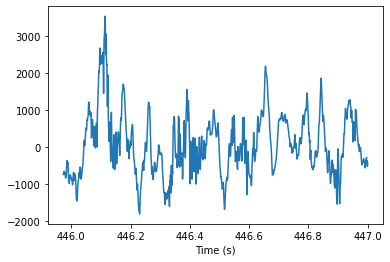

In [3]:
frequency = 1250.0

lfp = data.load_lfp(channel=15,extension='.eeg',frequency=frequency)

lfpsleep = lfp.restrict(sleep_ep)

figure()
plot(lfpsleep.restrict(ex_ep).as_units('s'))
xlabel("Time (s)")
show()

Then we can filter the lfp in the desired band in this case 100-300 Hz with the function bandpass_filter

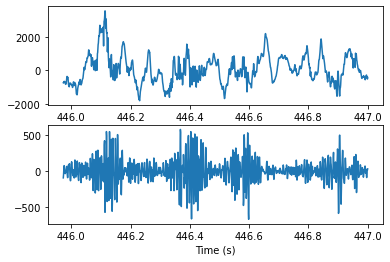

In [4]:
signal = pyna.eeg_processing.bandpass_filter(lfpsleep, 100, 300, frequency)

figure()
subplot(211)
plot(lfpsleep.restrict(ex_ep).as_units('s'))
subplot(212)
plot(signal.restrict(ex_ep).as_units('s'))
xlabel("Time (s)")
show()

Second step is to look at the enveloppe of the filtered signal.

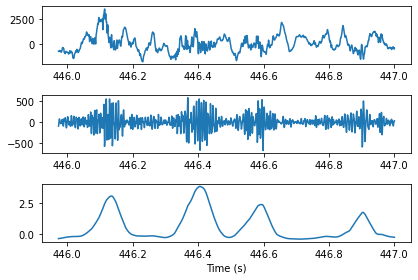

In [5]:
windowLength = 51

from scipy.signal import filtfilt

squared_signal = np.square(signal.values)
window = np.ones(windowLength)/windowLength
nSS = filtfilt(window, 1, squared_signal)
nSS = (nSS - np.mean(nSS))/np.std(nSS)
nSS = nap.Tsd(t = signal.index.values, d = nSS, time_support = signal.time_support)

figure()
subplot(311)
plot(lfpsleep.restrict(ex_ep).as_units('s'))
subplot(312)
plot(signal.restrict(ex_ep).as_units('s'))
subplot(313)
plot(nSS.restrict(ex_ep).as_units('s'))
xlabel("Time (s)")
tight_layout()
show()


Then we can apply a threshold

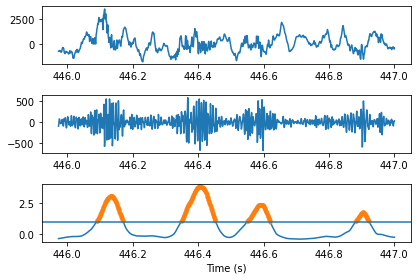

In [6]:
low_thres = 1
high_thres = 10

nSS2 = nSS.threshold(low_thres, method='above')
nSS3 = nSS2.threshold(high_thres, method='below')

figure()
subplot(311)
plot(lfpsleep.restrict(ex_ep).as_units('s'))
subplot(312)
plot(signal.restrict(ex_ep).as_units('s'))
subplot(313)
plot(nSS.restrict(ex_ep).as_units('s'))
plot(nSS3.restrict(ex_ep).as_units('s'), '.')
axhline(low_thres)
xlabel("Time (s)")
tight_layout()
show()

The ripples epochs are contained in the time support of nSS3. Now we can exclude ripple events that are too long or too shorts.

In [7]:
minRipLen = 20 # ms
maxRipLen = 200 # ms

rip_ep = nSS3.time_support
rip_ep = rip_ep.drop_short_intervals(minRipLen, time_units = 'ms')
rip_ep = rip_ep.drop_long_intervals(maxRipLen, time_units = 'ms')

print(rip_ep)

          start       end
0      0.736000    0.8116
1      0.887600    0.9580
2      1.033199    1.1196
3      1.643600    1.7172
4      1.780400    1.8444
..          ...       ...
611  595.015600  595.0476
612  597.230800  597.3140
613  597.962000  597.9892
614  598.460400  598.5268
615  599.650000  599.7384

[616 rows x 2 columns]


Final step is to merge ripples that are closer together than a given threshold

In [8]:
minInterRippleInterval = 20 # ms
rip_ep = rip_ep.merge_close_intervals(minInterRippleInterval, time_units = 'ms')
rip_ep = rip_ep.reset_index(drop=True)

Here I defined the center of the ripples as the time of the maximum value in the normalized square signal

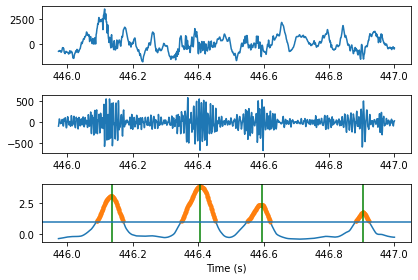

In [9]:
rip_max = []
rip_tsd = []
for s, e in rip_ep.values:
    tmp = nSS.loc[s:e]
    rip_tsd.append(tmp.idxmax())
    rip_max.append(tmp.max())

rip_max = np.array(rip_max)
rip_tsd = np.array(rip_tsd)

rip_tsd = nap.Tsd(t = rip_tsd, d = rip_max, time_support = sleep_ep)

figure()
subplot(311)
plot(lfpsleep.restrict(ex_ep).as_units('s'))
subplot(312)
plot(signal.restrict(ex_ep).as_units('s'))
subplot(313)
plot(nSS.restrict(ex_ep).as_units('s'))
plot(nSS3.restrict(rip_ep.intersect(ex_ep)).as_units('s'), '.')
[axvline(t, color = 'green') for t in rip_tsd.restrict(ex_ep).as_units('s').index.values]
axhline(low_thres)
xlabel("Time (s)")
tight_layout()
show()

There are a few utilities function to streamline this process and check the output. The first one is saving the ripple epochs in a format readable by neuroscope. It's a good way to check the quality of the ripple detection

In [10]:
data.write_neuroscope_intervals(extension='.evt.rip', isets=rip_ep, name='Ripples')

![image](screenshot_neuroscope_ripple_detection.png)

Next step is to save the ripples times into the NWB format. We can use the data.save_nwb_intervals and data.save_nwb_timeseries for this.

In [11]:
data.save_nwb_intervals(rip_ep, 'sleep_ripples')
data.save_nwb_timeseries(rip_tsd, 'sleep_ripples')

We can use the same interface to retrieve them for future analysis.

In [12]:
rip_ep = data.load_nwb_intervals('sleep_ripples')
rip_tsd = data.load_nwb_timeseries('sleep_ripples')

print(rip_tsd)

Time (s)
0.7712      7.914229
0.9232      4.948668
1.0744      5.199694
1.6832      6.297212
1.8112      2.984881
              ...   
595.0304    1.449906
597.2712    6.576559
597.9744    1.223363
598.4904    3.645475
599.6944    8.550653
Length: 594, dtype: float64
